In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import networkx as nx
import os
import pandas as pd
import random
import scipy.linalg
import seaborn as sns
import time
from tqdm.notebook import tqdm
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
%matplotlib inline

In [2]:
class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))


path = 'result/random_delay_unit'
if not os.path.exists(path):
    os.makedirs(path)

dataset shape: (2, 20000)


  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.168004174646514
err:  4.168004174646514
(100, 9999) (3, 9999)


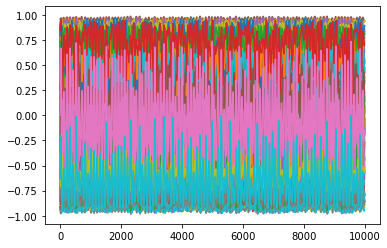

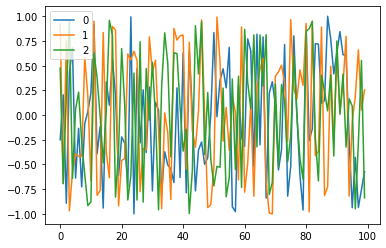

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.203724744550394
err:  4.203724744550394
(100, 9999) (3, 9999)


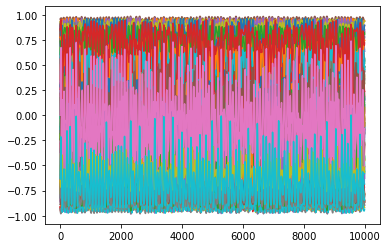

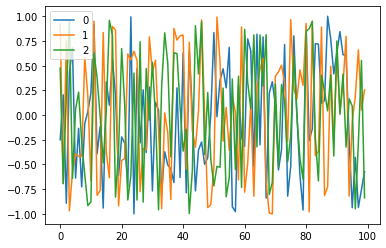

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.203724742312188
err:  4.203724742312188
(100, 9999) (3, 9999)


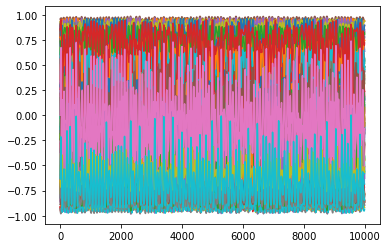

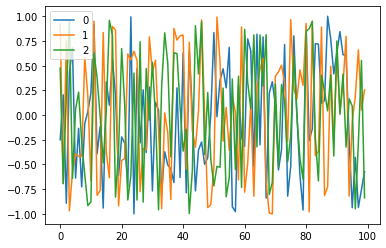

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.203724740074373
err:  4.203724740074373
(100, 9999) (3, 9999)


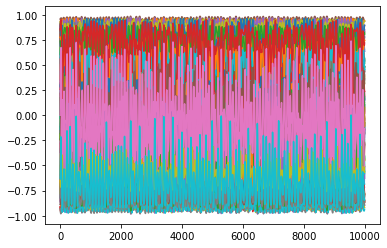

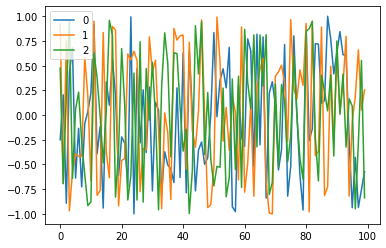

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.203724737836293
err:  4.203724737836293
(100, 9999) (3, 9999)


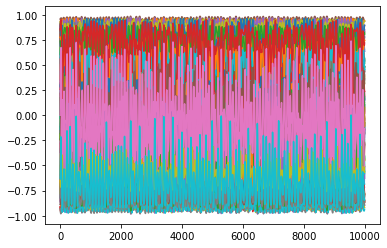

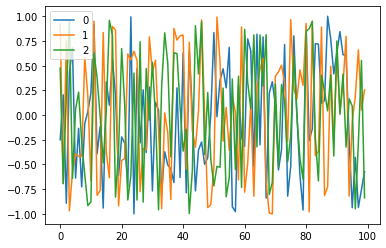

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.203724735597875
err:  4.203724735597875
(100, 9999) (3, 9999)


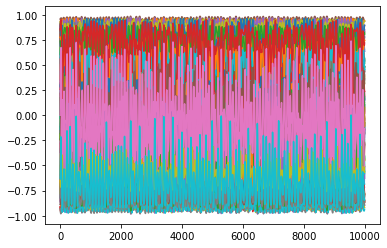

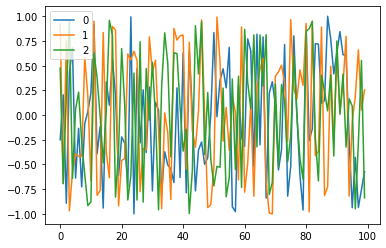

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.203724733360163
err:  4.203724733360163
(100, 9999) (3, 9999)


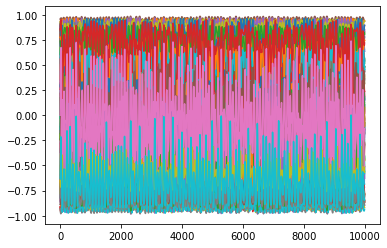

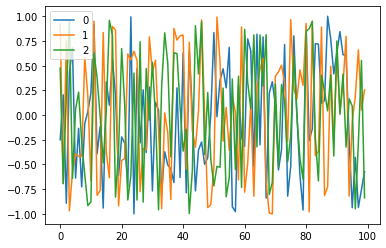

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.203724731122491
err:  4.203724731122491
(100, 9999) (3, 9999)


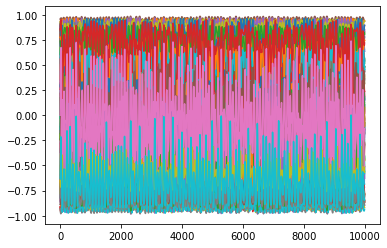

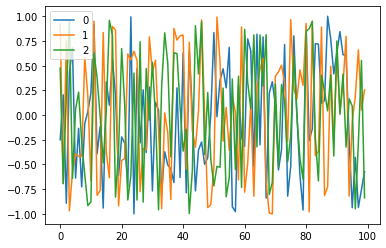

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.2037247288839055
err:  4.2037247288839055
(100, 9999) (3, 9999)


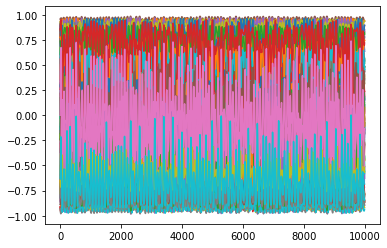

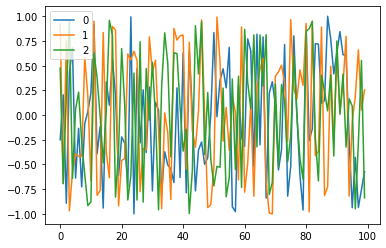

  0%|          | 0/20000 [00:00<?, ?it/s]

pre_output shape: (101, 10000)
W_out shape: (2, 101)
err:  4.2037247266459845
err:  4.2037247266459845
(100, 9999) (3, 9999)


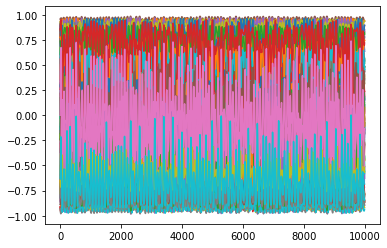

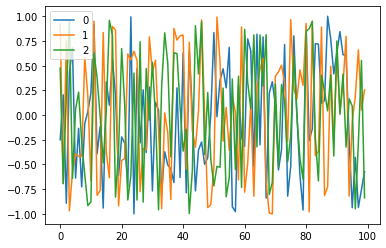

In [42]:

system_name1 = 'Lorenz'
U1 = np.loadtxt('dataset/matlab_gendata/'+system_name1+'.csv', delimiter=',').T[0]
system_name2 = 'Rossler'
U2 = np.loadtxt('dataset/matlab_gendata/'+system_name2+'.csv', delimiter=',').T[0]
U = np.vstack([U1,U2])
# U= U1
U = U + np.random.randn(*U.shape)*1e-3
U = np.atleast_2d(U)
num_prepare = 1000
train_start = num_prepare
num_train = 10000
val_start = num_prepare + num_train
num_val = 1000
test_start = num_prepare + num_train + num_val
num_test = 5000
print('dataset shape:', U.shape)

seed = 42
random.seed(seed) 
np.random.seed(seed)

inSize = U.shape[0]
outSize = inSize  
resSize = 100
a = 0.1           # leaking rate
K = 1.8          # spectial redius
reg = 1e-6     # regularization coefficient 
input_scaling = 1
sparsity = 0.1


# generation of random weights
Win = (np.random.rand(resSize,1+inSize)-0.5) *2* input_scaling
# Win[:resSize//2,1] = 0
# Win[resSize//2:,2] = 0
W = np.random.rand(resSize,resSize)-0.5
# W[:resSize//2,resSize//2:] = 0
# W[resSize//2:,:resSize//2] = 0
# g = nx.erdos_renyi_graph(resSize, sparsity, seed, True)
# W = nx.adjacency_matrix(g).todense()

largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
rhoW = np.sqrt(largest_eigvals[0])
W = W/rhoW*K 

for _ in range(10):
    X = np.zeros((resSize,U.shape[1]))
    x = np.zeros([resSize,1])
    for t in tqdm(range(U.shape[1])):
        u = U[:,t:t+1]
        x = (1-a) * x + a * np.tanh( Win @ np.vstack((1,u)) + W @ x )        
        X[:,t:t+1] = x


    # offline train
    U_train = U[:,train_start : train_start + num_train]
    X_train = X[:,train_start : train_start + num_train]
    Y_train = U[:,train_start + 1 : train_start + num_train + 1]
    H = np.vstack((np.ones((1,X_train.shape[1])),X_train))

    Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
    print('pre_output shape:', H.shape)
    print('W_out shape:', Wout.shape)
    print('err: ',np.sum(np.square(Y_train - Wout @ H)))

    # print(X_train[:,1:] - (1-a)*X_train[:,:-1] - a*np.tanh(W@ X_train[:,:-1] + Win @ np.vstack((np.ones((1,num_train-1)),U_train[:,1:]))))
    
    Win = adjustWin(Wout, Y_train, lr=0.99)

# multistep

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

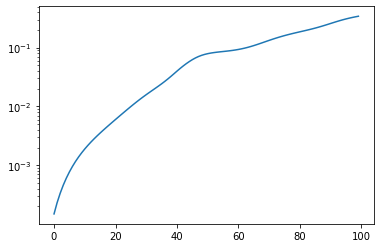

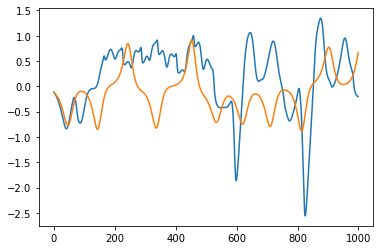

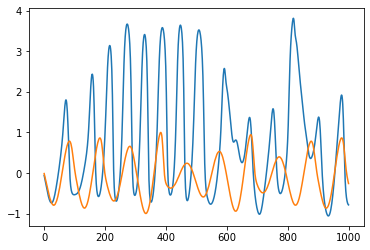

In [35]:
horizon = 100
mse = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred      
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
            
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
    mse.append(np.average(np.square(Y_pred - Y_true)[0]))

plt.figure()
plt.plot(mse) 
plt.yscale('log')

num_test = 1
horizon = 1000
pred = np.zeros((outSize,horizon))
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
           
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    pred[:,h:h+1] = Y_pred

plt.figure()
plt.plot(pred[0])
plt.plot(U[0,test_start : test_start + horizon])
plt.figure()
plt.plot(pred[1])
plt.plot(U[1,test_start : test_start + horizon])

  0%|          | 0/100 [00:00<?, ?it/s]

3.0578994683186204e-05


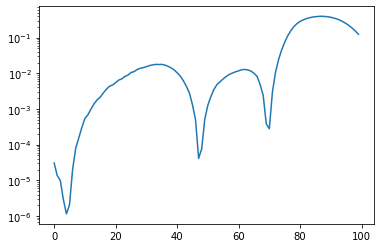

In [36]:

horizon = 100
mse = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )

    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    Y_true = U[:,test_start+h+1 : test_start + num_test + h+1]
    mse.append(np.average(np.square(Y_pred - Y_true)[0]))

plt.figure()
plt.plot(mse) 
plt.yscale('log')
print(mse[0])
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

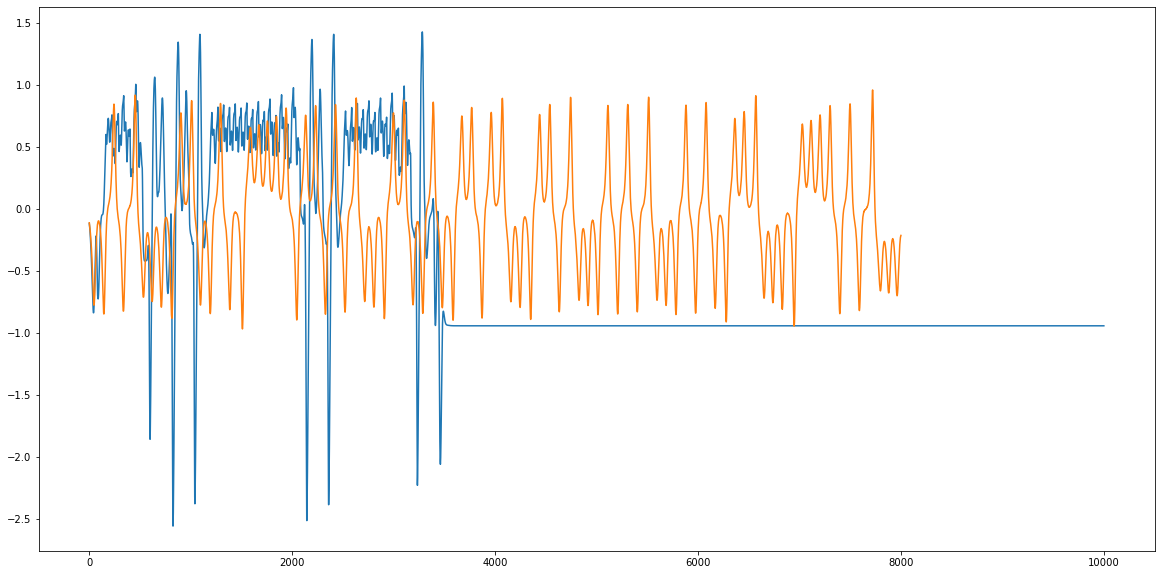

In [37]:
num_test = 1
horizon = 10000
pred = []
for h in tqdm(range(horizon)):
    if h == 0:
        U_test = U[:,test_start : test_start + num_test]
        X_test = X[:,test_start : test_start + num_test]
    else:
        U_test = Y_pred
        X_test = (1-a) * X_test + a * np.tanh( Win @ np.vstack((np.ones((1,num_test)),U_test)) + W @ X_test )
           
    H = np.vstack((np.ones((1,num_test)),X_test))
    Y_pred = Wout @ H
    pred.append(Y_pred[0])

plt.figure(figsize=(20,10))
plt.plot(pred)
plt.plot(U[0,test_start : test_start + horizon])

In [40]:
def adjustWin(Wout, Y_train, lr = 0.99): 
    Y1 = Y_train - Wout[:,:1]
    Wout1 = Wout[:,1:]
    XX = np.linalg.inv( Wout1.T @ Wout1 + reg*np.eye(Wout1.shape[1])) @ Wout1.T @ Y1

#     X1 = lr*XX + (1-lr)*X_train
    X1 = X_train
    # _ = plt.plot(X_train.T)
    plt.figure()
    _ =plt.plot(X1.T)

    H1 = np.vstack((np.ones((1,X1.shape[1])),X1))
    print('err: ',np.sum(np.square(Y_train - Wout @ H1)))
    
    X1t, X1t1 = X1[:,:-1], X1[:,1:]

    # L = np.arctanh((X1t1 - (1-a)*X1t)/a)
    # R = np.vstack([X1t,np.ones((1,num_train-1)), U_train[:,1:]])
    # print(L.shape, R.shape)
    # W2 = L @ R.T @ np.linalg.inv(R @ R.T)

    L = np.arctanh((X1t1 - (1-a)*X1t)/a) - W @ X1t
    R = np.vstack([np.ones((1,num_train-1)), U_train[:,1:]])
    print(L.shape, R.shape)
    Win = L @ R.T @ np.linalg.inv(R @ R.T+reg*np.ones(R.shape[0]))

    Wmax,Wmin = np.max(Win), np.min(Win)
    Win = (Win - Wmin)/(Wmax-Wmin)*2-1
    plt.figure()
    plt.plot(Win)
    plt.legend([str(i) for i in range(Win.shape[1])])
    plt.show()
    return Win